<a href="https://colab.research.google.com/github/Ali-Hassan96/Traffic-Stops-Analysis/blob/main/DSC473_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Traffic Stops Analysis: Unveiling Patterns and Insights in Law Enforcement Data**

!pip install pyspark is a command used to swiftly install PySpark, a Python API for Apache Spark, a robust distributed computing system. Executed in environments like Jupyter Notebooks or Google Colab

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d1cfc16f3f62e2a86ca7350110435287c1e27dc15c5e3f4ed87b6a696ac7d85a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark



The 'df' DataFrame holds diverse data on traffic stops in Washington. It includes columns like 'id', 'state', 'stop_date', 'stop_time', 'location', 'county', 'driver details', 'violation type', 'search details', 'stop outcome', and 'enforcement information'. This dataset covers comprehensive details about traffic stops and can be analyzed for insights into traffic patterns, demographics, and law enforcement practices in Washington.

In [2]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("ali").getOrCreate()

# Read a CSV file into a DataFrame
df = spark.read.csv("/content/WA.csv", header=True, inferSchema=True)

# Show the DataFrame
df.show()

+---------------+-----+----------+-------------------+------------+----------------+-----------+---------------------+-----------------+-------------+--------------+----------+----------------+-----------+--------------------+--------------------+----------------+------------------+------------------+----------------+------------------+-----------+-----------+----------+--------------+------------+------------+-----------+--------+----------+------------+--------------------+------------+------------------+
|             id|state| stop_date|          stop_time|location_raw|     county_name|county_fips|fine_grained_location|police_department|driver_gender|driver_age_raw|driver_age| driver_race_raw|driver_race|       violation_raw|           violation|search_conducted|   search_type_raw|       search_type|contraband_found|      stop_outcome|is_arrested| violations|officer_id|officer_gender|officer_race|highway_type|road_number|milepost|       lat|         lon|        contact_type|enforce


The 'describe()' function on DataFrame 'df' summarizes statistics for various columns like 'driver_age', 'violations', and 'officer_id', showcasing counts, means, and min-max values.

In [3]:
df.describe().show()

+-------+---------------+-----+------------+-------------+------------------+---------------------+-----------------+-------------+------------------+------------------+----------------+-----------+------------------+----------+---------------+----------------+------------------+-----------+-----------------+-----------------+--------------+------------+------------+------------------+------------------+------------------+-------------------+--------------------+------------------+
|summary|             id|state|location_raw|  county_name|       county_fips|fine_grained_location|police_department|driver_gender|    driver_age_raw|        driver_age| driver_race_raw|driver_race|     violation_raw| violation|search_type_raw|     search_type|      stop_outcome|is_arrested|       violations|       officer_id|officer_gender|officer_race|highway_type|       road_number|          milepost|               lat|                lon|        contact_type|      enforcements|
+-------+---------------+-


The 'printSchema()' function displays the schema structure of the DataFrame 'df', showcasing the data types and whether a field can contain null values. For example, it indicates that 'stop_date' is of type 'date', 'stop_time' is of type 'timestamp', and various other columns are either of type 'string', 'double', 'integer', or 'boolean'. The 'explain' function, when applied directly to the DataFrame

In [4]:
df.printSchema() #Inspect the schema to understand the data types

root
 |-- id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- stop_date: date (nullable = true)
 |-- stop_time: timestamp (nullable = true)
 |-- location_raw: string (nullable = true)
 |-- county_name: string (nullable = true)
 |-- county_fips: integer (nullable = true)
 |-- fine_grained_location: string (nullable = true)
 |-- police_department: string (nullable = true)
 |-- driver_gender: string (nullable = true)
 |-- driver_age_raw: double (nullable = true)
 |-- driver_age: double (nullable = true)
 |-- driver_race_raw: string (nullable = true)
 |-- driver_race: string (nullable = true)
 |-- violation_raw: string (nullable = true)
 |-- violation: string (nullable = true)
 |-- search_conducted: boolean (nullable = true)
 |-- search_type_raw: string (nullable = true)
 |-- search_type: string (nullable = true)
 |-- contraband_found: boolean (nullable = true)
 |-- stop_outcome: string (nullable = true)
 |-- is_arrested: string (nullable = true)
 |-- violations: string 

In [5]:
df.groupBy('driver_gender').count().show()

+-------------+-----+
|driver_gender|count|
+-------------+-----+
|            F|  823|
|         NULL| 1942|
|            M| 1988|
+-------------+-----+



combining the 'stop_date' and 'stop_time' columns into a new 'stop_datetime' column, converting it to a timestamp format, and then extracting the month into a new column called 'month'.

In [6]:
from pyspark.sql.functions import concat_ws, to_timestamp

# Creating stop_datetime column by combining stop_date and stop_time
df = df.withColumn('stop_datetime', concat_ws(' ', df.stop_date, df.stop_time))

# Converting stop_datetime to timestamp format
df = df.withColumn('stop_datetime', to_timestamp('stop_datetime', 'yyyy-MM-dd HH:mm'))

In [7]:
from pyspark.sql.functions import month

# Adding a 'month' column extracting month from stop_datetime
df = df.withColumn('month', month('stop_datetime'))

The output shows the number of missing values in each column, demonstrating where data might be incomplete. Additionally, it seems that the last two columns, 'stop_datetime' and 'month', have the same count as the DataFrame's total count, indicating that these columns might not have been transformed successfully or might have encountered an issue during the transformation.

In [8]:
from pyspark.sql.functions import col

# Counting missing values in each column
missing_values = df.select([col(c).alias(c) for c in df.columns]).toPandas().isnull().sum()

# Displaying the count of missing values for each column
print("Missing Values per Column:")
print(missing_values)

Missing Values per Column:
id                          0
state                       0
stop_date                   0
stop_time                   0
location_raw              554
county_name               554
county_fips               554
fine_grained_location       0
police_department        4753
driver_gender            1942
driver_age_raw           1958
driver_age               1958
driver_race_raw          1944
driver_race              1944
violation_raw            1945
violation                1945
search_conducted            0
search_type_raw          1944
search_type              4558
contraband_found            0
stop_outcome             1972
is_arrested              4753
violations               1945
officer_id                  0
officer_gender              0
officer_race                0
highway_type                0
road_number                 0
milepost                  427
lat                       554
lon                       554
contact_type               11
enforcements 

the row count and the number of columns in your DataFrame. This information provides a clear understanding of the size and structure of my dataset, which is essential for further analysis and transformations.

In [9]:
# Number of rows
row_count = df.count()
print("Number of rows:", row_count)

# Number of columns
column_count = len(df.columns)
print("Number of columns:", column_count)

Number of rows: 4753
Number of columns: 36


the first few rows of the DataFrame, printed the schema, and checking for missing values using the describe() function. also extracting summary statistics for the numerical columns. It's helpful to review the data structure, understand its contents, and identify any potential issues or missing values that might require handling.

In [10]:
# Show the first few rows
df.show(5)

# Print the schema
df.printSchema()

# Check for missing values
df.describe().show()

# Summary statistics for numerical columns
df.describe().toPandas().transpose()

+---------------+-----+----------+-------------------+------------+--------------+-----------+---------------------+-----------------+-------------+--------------+----------+---------------+-----------+--------------------+--------------------+----------------+------------------+------------------+----------------+------------------+-----------+----------+----------+--------------+------------+------------+-----------+--------+---------+-----------+--------------------+------------+------------------+-------------+-----+
|             id|state| stop_date|          stop_time|location_raw|   county_name|county_fips|fine_grained_location|police_department|driver_gender|driver_age_raw|driver_age|driver_race_raw|driver_race|       violation_raw|           violation|search_conducted|   search_type_raw|       search_type|contraband_found|      stop_outcome|is_arrested|violations|officer_id|officer_gender|officer_race|highway_type|road_number|milepost|      lat|        lon|        contact_type

,0,1,2,3,4
summary,count,mean,stddev,min,max
id,4753,None,None,WA-2009-0000001,WA-2009-0004753
state,4753,None,None,WA,WA
location_raw,4199,None,None,Adams,Yakima
county_name,4199,None,None,Adams County,Yakima County
county_fips,4199,53042.67182662539,19.829380472933558,53001,53077
fine_grained_location,4753,None,None,C-001-NA,S-CMP-8
police_department,0,None,None,None,None
driver_gender,2811,None,None,F,M
driver_age_raw,2795,35.92737030411449,14.297336654879278,15.0,89.0


check for missing values in the DataFrame columns, converting specific string columns to categorical type, and providing summary statistics for numerical columns. Additionally, showcased unique value counts for categorical columns like 'state' and 'driver_gender'. This analysis helps understand the distribution of data, identify missing values, and categorize relevant columns appropriately.

In [11]:
# Check for missing values in columns
from pyspark.sql.functions import col

# Count missing values per column
missing_values = df.select([col(c).alias(c) for c in df.columns]).toPandas().isnull().sum()

# Show missing values count
print("Missing Values per Column:")
print(missing_values)

# Convert string columns to categorical (if applicable)
categorical_columns = ['state', 'driver_gender']  # Update with relevant columns
for col_name in categorical_columns:
    df = df.withColumn(col_name, df[col_name].cast('string'))

# Summary statistics for numerical columns
num_summary = df.describe().toPandas()
print("Summary Statistics for Numerical Columns:")
print(num_summary)

# Count unique values for categorical columns
categorical_columns = ['state', 'driver_gender']  # Update with relevant columns
for col_name in categorical_columns:
    unique_values = df.groupBy(col_name).count().orderBy('count', ascending=False)
    unique_values.show()

Missing Values per Column:
id                          0
state                       0
stop_date                   0
stop_time                   0
location_raw              554
county_name               554
county_fips               554
fine_grained_location       0
police_department        4753
driver_gender            1942
driver_age_raw           1958
driver_age               1958
driver_race_raw          1944
driver_race              1944
violation_raw            1945
violation                1945
search_conducted            0
search_type_raw          1944
search_type              4558
contraband_found            0
stop_outcome             1972
is_arrested              4753
violations               1945
officer_id                  0
officer_gender              0
officer_race                0
highway_type                0
road_number                 0
milepost                  427
lat                       554
lon                       554
contact_type               11
enforcements 

 top violations analysis is quite revealing 'Speeding' stands out as the most frequent violation, followed by 'Safe movement' and various combinations like 'Paperwork,Speeding' and 'Registration/plates'. Interestingly, there's a significant count of NULL values in the 'violation' column that might need attention or further investigation to handle.

In [12]:
from pyspark.sql.functions import desc

# Grouping by 'violation' and counting occurrences
top_violations = df.groupBy('violation').count().orderBy('count', ascending=False).limit(10)

# Displaying the top 10 most frequent violations
top_violations.show()

+--------------------+-----+
|           violation|count|
+--------------------+-----+
|                NULL| 1945|
|            Speeding|  898|
|       Safe movement|  477|
|  Paperwork,Speeding|  190|
| Registration/plates|  113|
|Safe movement,Spe...|  111|
|Paperwork,Registr...|  101|
|               Other|   92|
|           Equipment|   74|
|Paperwork,Safe mo...|   64|
+--------------------+-----+



 clear gender distribution among drivers in the dataset. With males accounting for 68.9% and females at 31.1%, it seems there's a significant prevalence of male drivers compared to female drivers. The donut chart visually represents this distribution, making it easier to grasp the gender ratio among drivers.

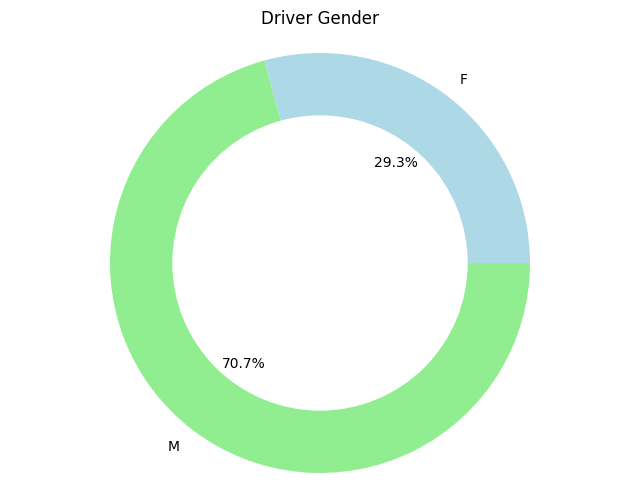

In [13]:
import matplotlib.pyplot as plt
# Filter out rows with missing values in 'driver_gender'
filtered_df = df.filter(df['driver_gender'].isNotNull())

# Calculate the counts of each driver gender in the filtered DataFrame
gender_counts = filtered_df.groupBy('driver_gender').count().toPandas()

# Extract labels and counts
labels = gender_counts['driver_gender']
counts = gender_counts['count']

# Create a donut chart without missing values
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])

# Draw a white circle at the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, color='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Driver Gender')
plt.axis('equal')
plt.show()

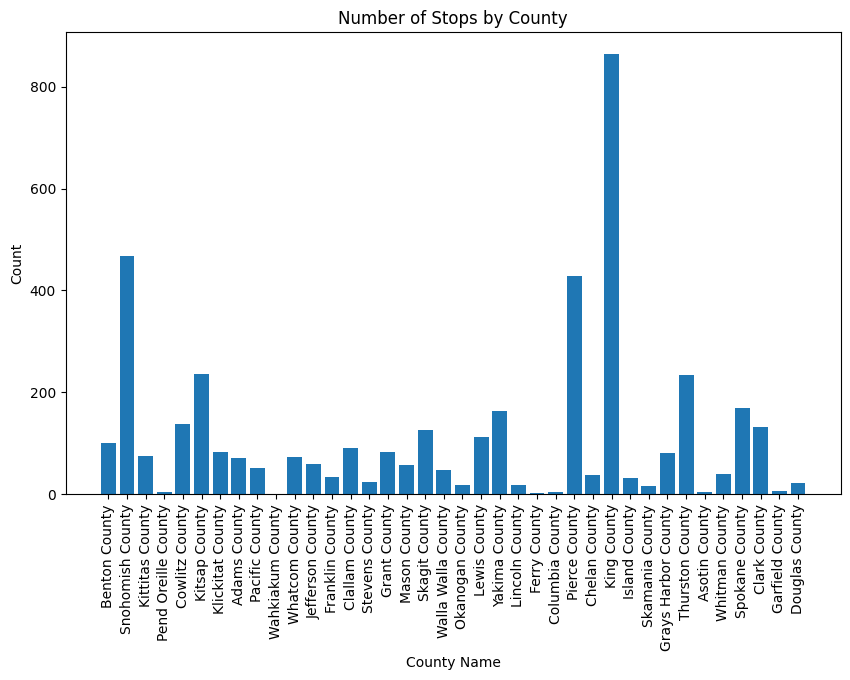

In [14]:
# Filter out null values in 'county_name' before collecting data
county_counts_data = df.filter(col('county_name').isNotNull()).groupBy('county_name').count().toPandas()

plt.figure(figsize=(10, 6))
plt.bar(county_counts_data['county_name'], county_counts_data['count'])
plt.xlabel('County Name')
plt.ylabel('Count')
plt.title('Number of Stops by County')
plt.xticks(rotation=90)
plt.show()

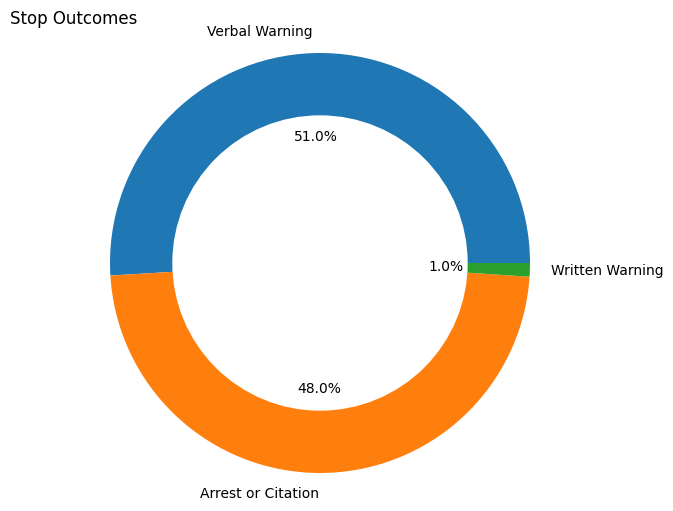

In [33]:
# Filtering out null values in 'stop_outcome' column
filtered_df = df.filter(df['stop_outcome'].isNotNull())

# Grouping by 'stop_outcome' and counting occurrences
stop_outcomes = filtered_df.groupBy('stop_outcome').count().orderBy('count', ascending=False).limit(10).toPandas()

# Plotting a donut chart
plt.figure(figsize=(8, 6))
plt.pie(stop_outcomes['count'], labels=stop_outcomes['stop_outcome'], autopct='%1.1f%%')

# Draw a white circle at the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, color='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set the title to the left
plt.title('Stop Outcomes', loc='left')
plt.axis('equal')
plt.show()

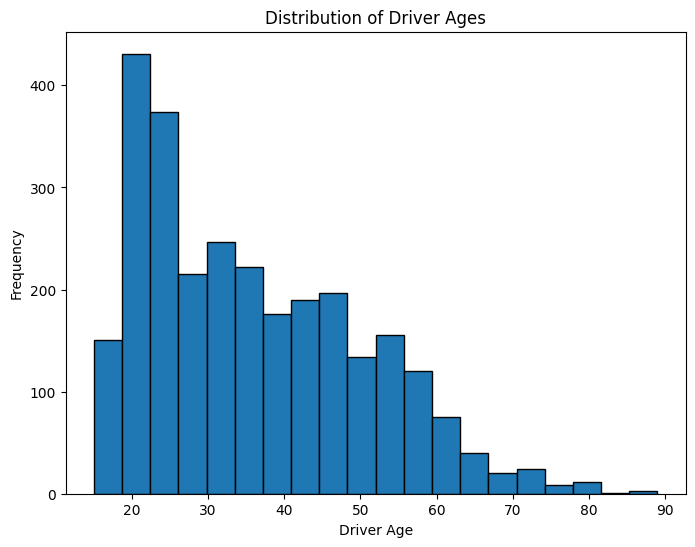

In [16]:
# Filtering out null values in 'driver_age' before plotting
driver_age_data = df.filter(col('driver_age').isNotNull()).select('driver_age').toPandas()

# Plotting histogram for driver ages
plt.figure(figsize=(8, 6))
plt.hist(driver_age_data['driver_age'], bins=20, edgecolor='black')
plt.xlabel('Driver Age')
plt.ylabel('Frequency')
plt.title('Distribution of Driver Ages')
plt.show()

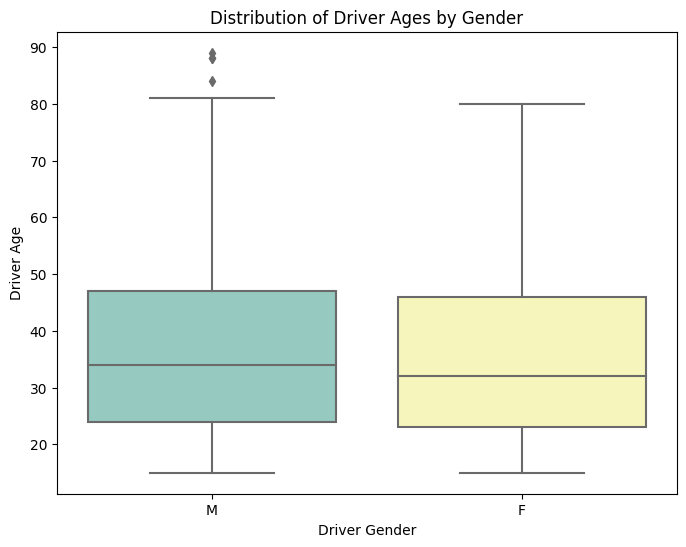

In [17]:
import seaborn as sns
# Filtering out null values and selecting driver ages and genders
driver_age_gender = df.filter(col('driver_age').isNotNull() & col('driver_gender').isNotNull()).select('driver_age', 'driver_gender').toPandas()

# Plotting boxplot for driver ages by gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=driver_age_gender, x='driver_gender', y='driver_age', palette='Set3')
plt.xlabel('Driver Gender')
plt.ylabel('Driver Age')
plt.title('Distribution of Driver Ages by Gender')
plt.show()

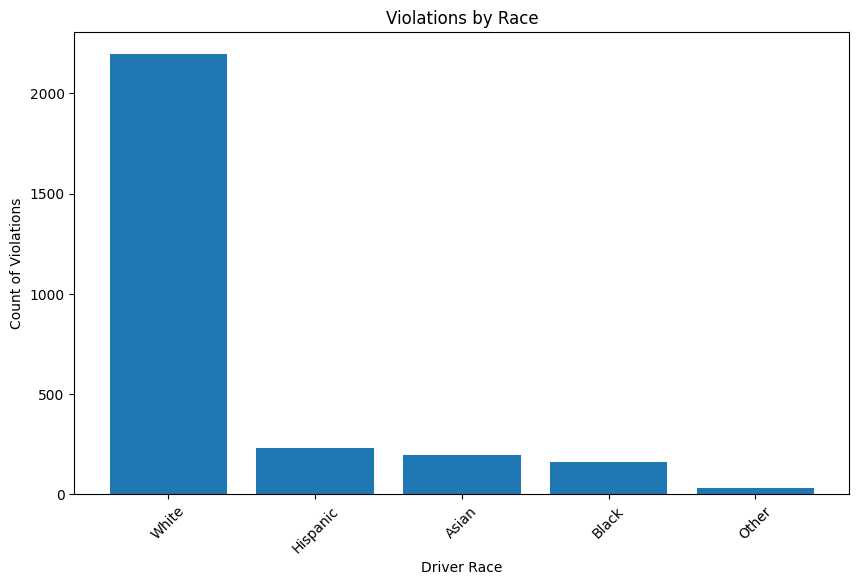

In [18]:
from pyspark.sql.functions import col

# Filtering out null values in 'driver_race' before counting violations
violation_counts_race = df.filter(col('driver_race').isNotNull()) \
                          .groupBy('driver_race').count().orderBy('count', ascending=False).toPandas()

# Plotting a bar chart for violations by race
plt.figure(figsize=(10, 6))
plt.bar(violation_counts_race['driver_race'], violation_counts_race['count'])
plt.xlabel('Driver Race')
plt.ylabel('Count of Violations')
plt.title('Violations by Race')
plt.xticks(rotation=45)
plt.show()

In [19]:
import plotly.express as px
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Filter out null values in 'driver_race', 'location_raw', and any other necessary columns
filtered_df = df.filter((col('driver_race').isNotNull()) & (col('location_raw').isNotNull()))

# Grouping by 'driver_race' and 'location_raw' and counting violations
violation_counts_race_city = filtered_df.groupBy('driver_race', 'location_raw').count().orderBy('driver_race', 'location_raw').toPandas()

# Create a Plotly figure for an interactive grouped bar chart
fig = px.bar(violation_counts_race_city, x='location_raw', y='count', color='driver_race',
             title='Violations by Race and City', labels={'count': 'Count of Violations'},
             barmode='group')

# Update layout for better readability
fig.update_layout(xaxis_title='City', yaxis_title='Count of Violations', xaxis_tickangle=-45)

# Show the interactive plot
fig.show()

In [20]:
# Counting occurrences of drugs_related_stop
drugs_related_stop_count = df.groupBy('drugs_related_stop').count().orderBy('count', ascending=False)

# Displaying the counts
drugs_related_stop_count.show()

+------------------+-----+
|drugs_related_stop|count|
+------------------+-----+
|             false| 4704|
|              true|   48|
|              NULL|    1|
+------------------+-----+



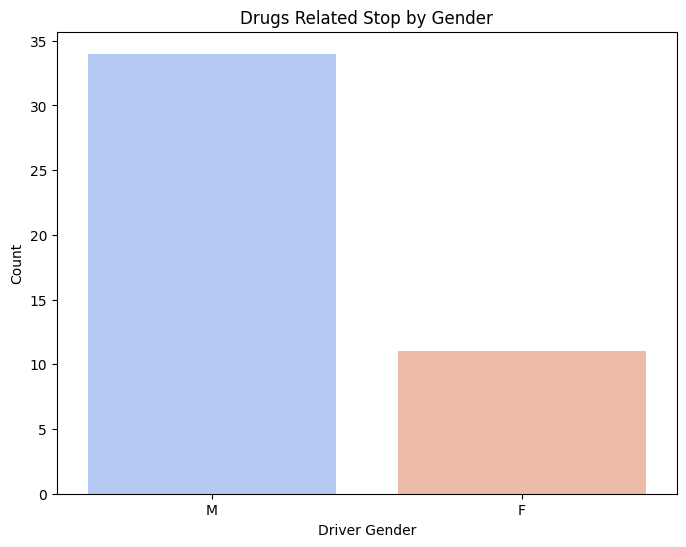

In [21]:
# Filtering data for drugs_related_stop = True and not null values in 'driver_gender' column
filtered_gender_df = df.filter((col('driver_gender').isNotNull()) & (col('drugs_related_stop') == True))

# Plotting count plot for drugs_related_stop = True vs driver_gender
plt.figure(figsize=(8, 6))
sns.countplot(data=filtered_gender_df.toPandas(), x='driver_gender', palette='coolwarm')
plt.xlabel('Driver Gender')
plt.ylabel('Count')
plt.title('Drugs Related Stop by Gender')
plt.show()

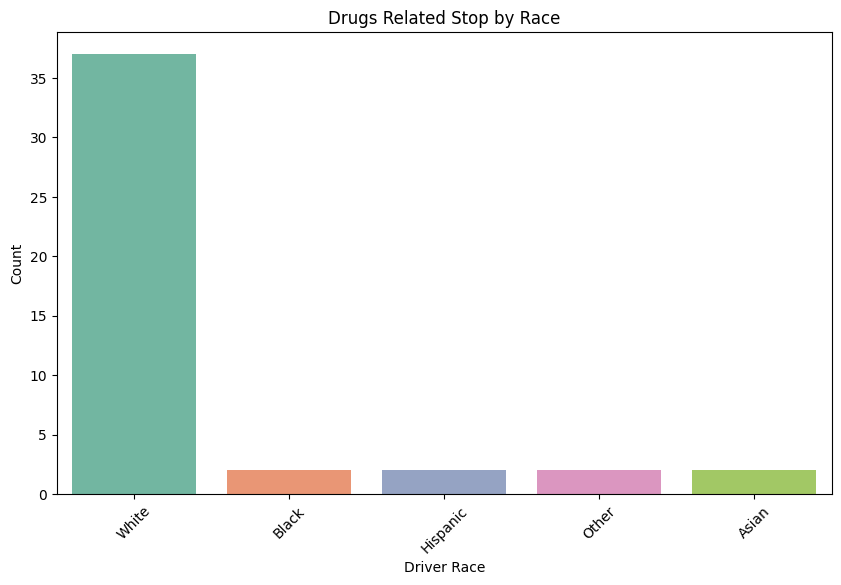

In [22]:
# Filtering data for drugs_related_stop = True and not null values in 'driver_race' column
filtered_race_df = df.filter((col('driver_race').isNotNull()) & (col('drugs_related_stop') == True))

# Plotting count plot for drugs_related_stop = True vs driver_race
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_race_df.toPandas(), x='driver_race', palette='Set2')
plt.xlabel('Driver Race')
plt.ylabel('Count')
plt.title('Drugs Related Stop by Race')
plt.xticks(rotation=45)
plt.show()

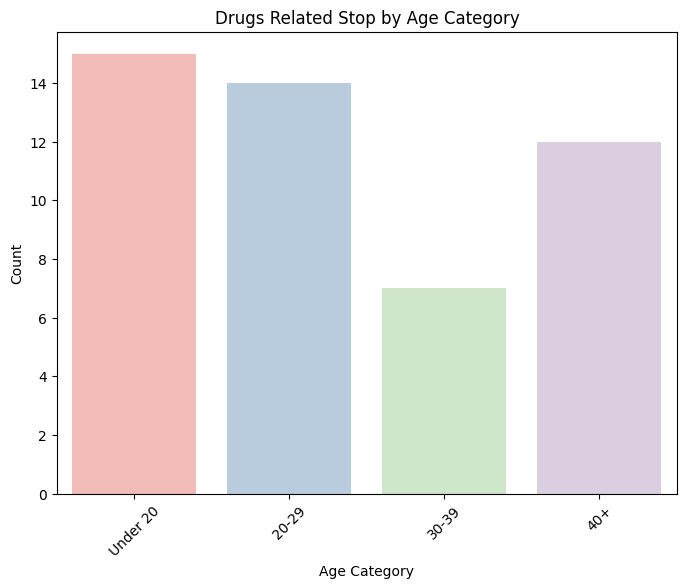

In [23]:
from pyspark.sql.functions import when, col

# Creating age categories
df_with_categories = df.withColumn(
    'age_category',
    when(df['driver_age'] < 20, 'Under 20')
    .when((df['driver_age'] >= 20) & (df['driver_age'] < 30), '20-29')
    .when((df['driver_age'] >= 30) & (df['driver_age'] < 40), '30-39')
    .otherwise('40+')
)

# Filtering data for drugs_related_stop = True and not null values in 'age_category' column
filtered_age_df = df_with_categories.filter((col('age_category').isNotNull()) & (col('drugs_related_stop') == True))

# Define the order of age categories
age_order = ['Under 20', '20-29', '30-39', '40+']

# Getting the count of each category and ordering by age
age_category_counts = (
    filtered_age_df.groupBy('age_category')
    .count()
    .orderBy(when(col('age_category').isin(age_order), col('age_category')), ascending=True)
)

# Plotting count plot for drugs_related_stop = True vs age_category
plt.figure(figsize=(8, 6))
sns.barplot(data=age_category_counts.toPandas(), x='age_category', y='count', order=age_order, palette='Pastel1')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.title('Drugs Related Stop by Age Category')
plt.xticks(rotation=45)
plt.show()

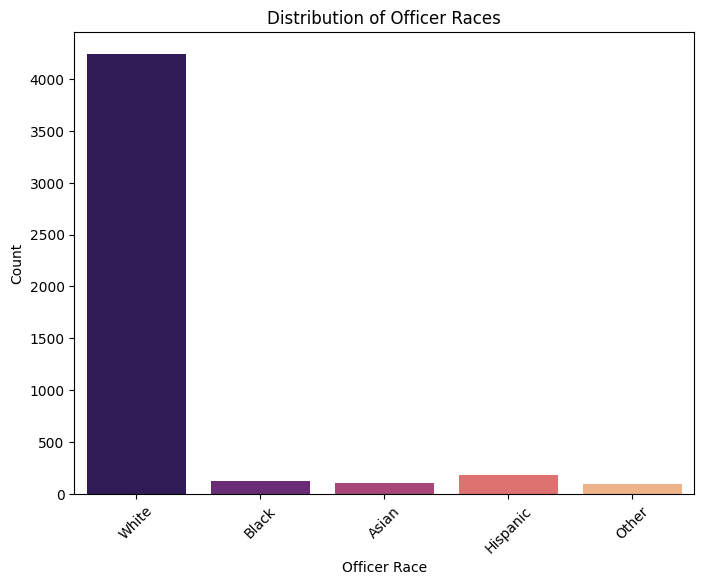

In [24]:
# Countplot for officer races
plt.figure(figsize=(8, 6))
sns.countplot(data=df.toPandas(), x='officer_race', palette='magma')
plt.xlabel('Officer Race')
plt.ylabel('Count')
plt.title('Distribution of Officer Races')
plt.xticks(rotation=45)
plt.show()

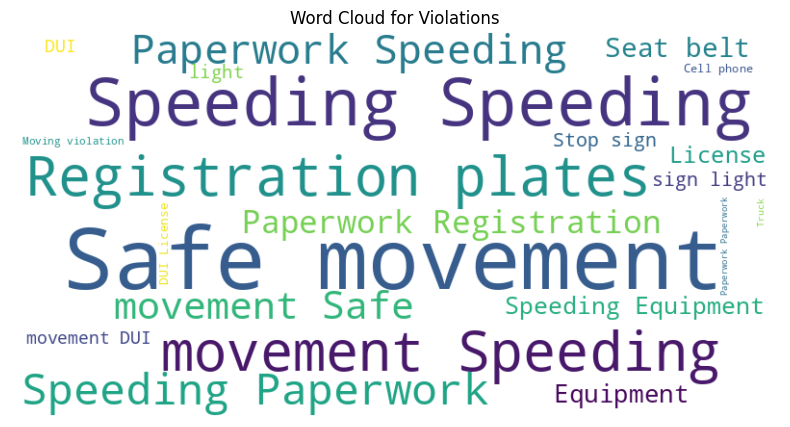

In [25]:
from wordcloud import WordCloud

# Filter out null values in 'violation' column
violations_text = ' '.join(df.filter(df['violation'].isNotNull()).select('violation').rdd.flatMap(lambda x: x).collect())

# Generate a word cloud for violations
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(violations_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Violations')
plt.show()

cleaned_df = df.dropna(subset=['stop_date']) eliminates rows with missing values specifically in the 'stop_date' column of the DataFrame 'df', creating a new DataFrame named 'cleaned_df'. This operation ensures that the resulting 'cleaned_df' DataFrame contains only rows where the 'stop_date' column has valid, non-null entries

In [26]:
cleaned_df = df.dropna(subset=['stop_date'])

using PySpark to fill missing values in the 'stop_date' column of the DataFrame 'df' with a default date ('2023-01-01'). By importing the lit function and defining default_date = '2023-01-01', the script utilizes the fillna() method to replace null values specifically in the 'stop_date' column with the provided default date, ensuring consistency in date entries within the resulting DataFrame 'cleaned_df' for further analysis or processing.

In [27]:
from pyspark.sql.functions import lit

default_date = '2023-01-01'  # Replace with the desired default date
cleaned_df = df.fillna({'stop_date': default_date})

This PySpark code defines a function handle_outliers to identify and handle outliers in a specified column within a DataFrame 'df'. The function utilizes the approxQuantile method to compute quartiles, determining the interquartile range (IQR) for outlier detection. It sets bounds using 1.5 times the IQR to filter outliers from the DataFrame 'df' based on the provided 'column_name'. The identified outliers are stored in 'outliers_df', while the cleaned DataFrame excluding outliers is stored in 'cleaned_df

In [28]:
from pyspark.sql.functions import col

# Define a function to handle outliers for a specific column
def handle_outliers(df, column_name):
    # Calculate quartiles for the specified column
    quartiles = df.approxQuantile(column_name, [0.25, 0.75], 0.05)
    q1 = quartiles[0]
    q3 = quartiles[1]

    # Calculate IQR
    iqr = q3 - q1

    # Define bounds for outlier detection
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter outliers and handle them (you can modify this part based on your strategy)
    outliers_df = df.filter((col(column_name) < lower_bound) | (col(column_name) > upper_bound))
    cleaned_df = df.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))

    return cleaned_df, outliers_df

# Example usage for a specific column 'driver_age'
cleaned_age_df, age_outliers = handle_outliers(df, 'driver_age')

In [29]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Define the output path for the Excel file
output_path = "/content/WA_output.xlsx"  # Replace with your desired output path and file name

# Save the Pandas DataFrame as an Excel file
pandas_df.to_excel(output_path, index=False)
